# CBOW 


## Continious Bag of Words

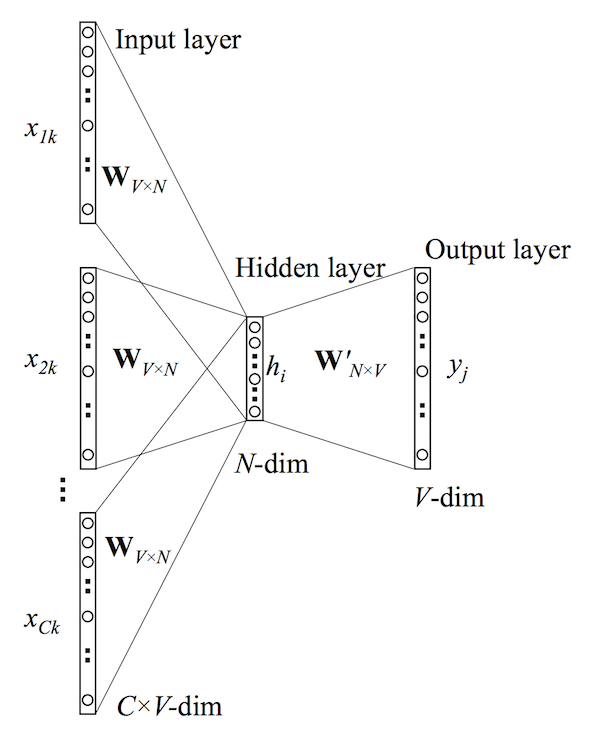

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import urllib.request
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import word_tokenize
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances


In [2]:

torch.manual_seed(1)

CONTEXT_SIZE = 3
EMBEDDING_DIM = 10

test_sentence = """Empathy for the poor may not come easily to people who never experienced it. They may blame the victims and insist their predicament can be overcome through determination and hard work.
But they may not realize that extreme poverty can be psychologically and physically incapacitating — a perpetual cycle of bad diets, health care and education exacerbated by the shaming and self-fulfilling prophecies that define it in the public imagination.
Gordon Parks — perhaps more than any artist — saw poverty as “the most savage of all human afflictions” and realized the power of empathy to help us understand it. It was neither an abstract problem nor political symbol, but something he endured growing up destitute in rural Kansas and having spent years documenting poverty throughout the world, including the United States.
That sensitivity informed “Freedom’s Fearful Foe: Poverty,” his celebrated photo essay published in Life magazine in June 1961. He took readers into the lives of a Brazilian boy, Flavio da Silva, and his family, who lived in the ramshackle Catacumba favela in the hills outside Rio de Janeiro. These stark photographs are the subject of a new book, “Gordon Parks: The Flavio Story” (Steidl/The Gordon Parks Foundation), which accompanies a traveling exhibition co-organized by the Ryerson Image Centre in Toronto, where it opens this week, and the J. Paul Getty Museum. Edited with texts by the exhibition’s co-curators, Paul Roth and Amanda Maddox, the book also includes a recent interview with Mr. da Silva and essays by Beatriz Jaguaribe, Maria Alice Rezende de Carvalho and Sérgio Burgi.
""".split()
# we should tokenize the input, but we will ignore that for now
# build a list of tuples.  Each tuple is ([ word_i-2, word_i-1 ], target word)

def get_key(word_id):
    for key,val in word_to_ix.items():
        if(val == word_id):
            print(key)

def cluster_embeddings(filename,nclusters):
    X = np.load(filename)
    kmeans = KMeans(n_clusters=nclusters, random_state=0).fit(X)
    center = kmeans.cluster_centers_
    distances = euclidean_distances(X,center)

    for i in np.arange(0,distances.shape[1]):
        word_id = np.argmin(distances[:,i])
        print(word_id)
        get_key(word_id)

def read_data(file_path):
    tokenizer = RegexpTokenizer(r'\w+')
    data = urllib.request.urlopen(file_path)
    data = data.read().decode('utf8')
    tokenized_data = word_tokenize(data)
    stop_words = set(stopwords.words('english'))
    stop_words.update(['.',',',':',';','(',')','#','--','...','"'])
    cleaned_words = [ i for i in tokenized_data if i not in stop_words ]
    return(cleaned_words)

#test_sentence = read_data('https://www.gutenberg.org/files/57884/57884-0.txt')

ngrams = []
for i in range(len(test_sentence) - CONTEXT_SIZE):
    tup = [test_sentence[j] for j in np.arange(i , i + CONTEXT_SIZE) ]
    ngrams.append((tup,test_sentence[i + CONTEXT_SIZE]))
# print the first 3, just so you can see what they look like
#print(ngrams)


vocab = set(test_sentence)
print("Length of vocabulary",len(vocab))
word_to_ix = {word: i for i, word in enumerate(vocab)}


class CBOWModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(CBOWModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))  # -1 implies size inferred for that index from the size of the data
        #print(np.mean(np.mean(self.linear2.weight.data.numpy())))
        out1 = F.relu(self.linear1(embeds)) # output of first layer
        out2 = self.linear2(out1)           # output of second layer
        #print(embeds)
        log_probs = F.log_softmax(out2, dim=1)
        return log_probs

    def predict(self,input):
        context_idxs = torch.tensor([word_to_ix[w] for w in input], dtype=torch.long)
        res = self.forward(context_idxs)
        res_arg = torch.argmax(res)
        res_val, res_ind = res.sort(descending=True)
        res_val = res_val[0][:3]
        res_ind = res_ind[0][:3]
        #print(res_val)
        #print(res_ind)
        for arg in zip(res_val,res_ind):
            #print(arg)
            print([(key,val,arg[0]) for key,val in word_to_ix.items() if val == arg[1]])

    def freeze_layer(self,layer):
        for name,child in model.named_children():
            print(name,child)
            if(name == layer):
                for names,params in child.named_parameters():
                    print(names,params)
                    print(params.size())
                    params.requires_grad= False

    def print_layer_parameters(self):
        for name,child in model.named_children():
                print(name,child)
                for names,params in child.named_parameters():
                    print(names,params)
                    print(params.size())

    def write_embedding_to_file(self,filename):
        for i in self.embeddings.parameters():
            weights = i.data.numpy()
        np.save(filename,weights)



losses = []
loss_function = nn.NLLLoss()
model = CBOWModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Freeze embedding layer
#model.freeze_layer('embeddings')


for epoch in range(400):
    total_loss = 0
    #------- Embedding layers are trained as well here ----#
    #lookup_tensor = torch.tensor([word_to_ix["poor"]], dtype=torch.long)
    #hello_embed = model.embeddings(lookup_tensor)
    #print(hello_embed)
    # -----------------------------------------------------#

    for context, target in ngrams:

        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
        #print("Context id",context_idxs)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = model(context_idxs)
        #print(log_probs)

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))
        #print(loss)

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
    print(total_loss)
    losses.append(total_loss)
#print(losses)  # The loss decreased every iteration over the training data!

#Print the model layer parameters
#model.print_layer_parameters()

#Predict the next word given n context words
model.predict(['of','all','human'])
model.write_embedding_to_file('embeddings.npy')
cluster_embeddings('embeddings.npy',2)

Length of vocabulary 195
1352.1469988822937
1342.945209980011
1333.8584961891174
1324.8771433830261
1315.9802885055542
1307.1602640151978
1298.4228780269623
1289.761862039566
1281.1786673069
1272.6762204170227
1264.2526235580444
1255.9123499393463
1247.6631016731262
1239.5179295539856
1231.4720575809479
1223.5276250839233
1215.6909790039062
1207.958884358406
1200.3289308547974
1192.798711180687
1185.357483625412
1178.0006054639816
1170.7104231119156
1163.4770489931107
1156.2834672927856
1149.1246700286865
1141.9814937710762
1134.8470563292503
1127.706303358078
1120.5653488636017
1113.4128580093384
1106.244754076004
1099.0481351017952
1091.822327554226
1084.5566450357437
1077.2437462806702
1069.888351738453
1062.4799390435219
1055.0194386839867
1047.5014896392822
1039.9286431074142
1032.2942872047424
1024.5994862914085
1016.8378973603249
1009.0069375038147
1001.1054280996323
993.1358848810196
985.0884391665459
976.9627341032028
968.7598255872726
960.4875130951405
952.1324217319489
943.6

C:\Users\ikaan\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


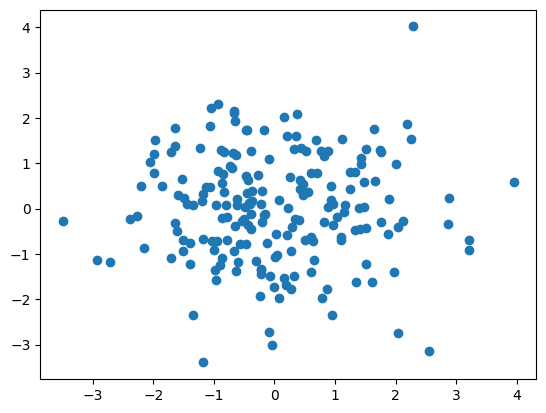

In [3]:
#apply PCA to visualize the embeddings with their label




